[*********************100%%**********************]  30 of 30 completed


Equal Weight Portfolio Metrics:
Annualized Mean Return: 0.010709635602744854
Annualized Return Standard Deviation: 0.03253251236118352
Sharpe Ratio: 0.32919792618055405
Maximum Drawdown: -0.07952357836676538
Maximum Diversification Portfolio Metrics:
Annualized Mean Return: 0.060925508037112795
Annualized Return Standard Deviation: 0.12355728442567311
Sharpe Ratio: 0.4930952336829888
Maximum Drawdown: -0.12113077192193489


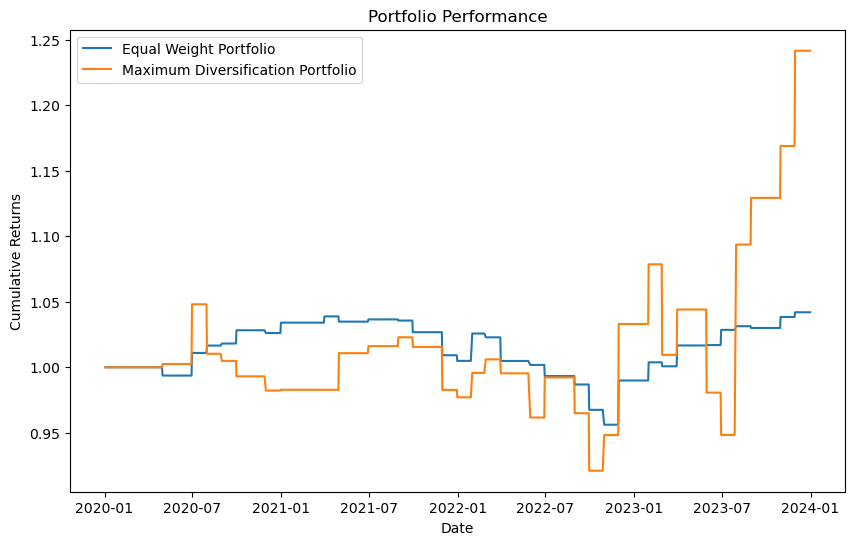

In [27]:
# (a)

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the ticker symbols for the 30 stocks (a diversified set from various sectors)
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "BRK-B", "JNJ", "V", "WMT",
    "JPM", "PG", "UNH", "DIS", "NVDA", "HD", "PYPL", "BAC", "VZ", "ADBE",
    "CMCSA", "NFLX", "KO", "NKE", "MRK", "PEP", "T", "PFE", "INTC", "CSCO"
]

# Define the backtest period
start_date = "2020-01-01"
end_date = "2023-12-31"

# Fetch the historical data
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

# Calculate daily returns
daily_returns = data.pct_change().dropna()


def rebalance_portfolio_with_lookahead(data, initial_weights, optimize=False):
    monthly_data = data.resample('M').ffill()
    monthly_returns = monthly_data.pct_change().dropna()
    rebalanced_weights = pd.DataFrame(index=monthly_returns.index, columns=monthly_returns.columns)

    for date in monthly_returns.index[:-1]:
        past_data = monthly_returns.loc[date:]
        cov_matrix = past_data.cov() * 12  # Annualized covariance matrix
        standard_deviation = past_data.std() * np.sqrt(12)
        if optimize:
            def neg_diversification_ratio(weights):
                weighted_volatility = np.dot(weights, standard_deviation)
                portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
                return -1 * (weighted_volatility / portfolio_volatility)
            
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            bounds = tuple((-1, 1) for _ in monthly_returns.columns)
            result = minimize(neg_diversification_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
            optimized_weights = result.x
            rebalanced_weights.loc[date] = optimized_weights
        else:
            rebalanced_weights.loc[date] = initial_weights

    return rebalanced_weights.shift(1).dropna()

# Initialize equal weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
initial_weights_MDP = np.array([1/len(tickers)] * len(tickers))

# Rebalance portfolios
equal_weights = rebalance_portfolio_with_lookahead(data, initial_weights, optimize=False)
MDP_weights = rebalance_portfolio_with_lookahead(data, initial_weights_MDP, optimize=True)

# Calculate cumulative returns for each portfolio
def calculate_cumulative_returns(data, weights):
    daily_returns = data.pct_change().dropna()
    portfolio_returns = (daily_returns * weights.shift(1)).sum(axis=1)
    cum_returns = (1 + portfolio_returns).cumprod()
    return cum_returns

cum_returns_equal = calculate_cumulative_returns(data, equal_weights)
cum_returns_optimized = calculate_cumulative_returns(data, MDP_weights)

# Calculate metrics
def calculate_metrics(cumulative_returns):
    daily_returns = cumulative_returns.pct_change().dropna()
    annualized_mean_return = np.mean(daily_returns) * 252
    annualized_std_dev = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = annualized_mean_return / annualized_std_dev
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return annualized_mean_return, annualized_std_dev, sharpe_ratio, max_drawdown

metrics_equal = calculate_metrics(cum_returns_equal)
metrics_optimized = calculate_metrics(cum_returns_optimized)

print("Equal Weight Portfolio Metrics:")
print(f"Annualized Mean Return: {metrics_equal[0]}")
print(f"Annualized Return Standard Deviation: {metrics_equal[1]}")
print(f"Sharpe Ratio: {metrics_equal[2]}")
print(f"Maximum Drawdown: {metrics_equal[3]}")

print("Maximum Diversification Portfolio Metrics:")
print(f"Annualized Mean Return: {metrics_optimized[0]}")
print(f"Annualized Return Standard Deviation: {metrics_optimized[1]}")
print(f"Sharpe Ratio: {metrics_optimized[2]}")
print(f"Maximum Drawdown: {metrics_optimized[3]}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_equal, label='Equal Weight Portfolio')
plt.plot(cum_returns_optimized, label='Maximum Diversification Portfolio')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



[*********************100%%**********************]  30 of 30 completed


- Equal Weight Portfolio Metrics:
Annualized Mean Return: 0.002356550843230759
Annualized Return Standard Deviation: 0.03047245293593993
Sharpe Ratio: 0.07733380861018206
Maximum Drawdown: -0.07952357836676538
- Maximum Diversification Portfolio Metrics:
Annualized Mean Return: 0.012980141025925767
Annualized Return Standard Deviation: 0.030487480982450556
Sharpe Ratio: 0.42575314875628784
Maximum Drawdown: -0.05718554969523448


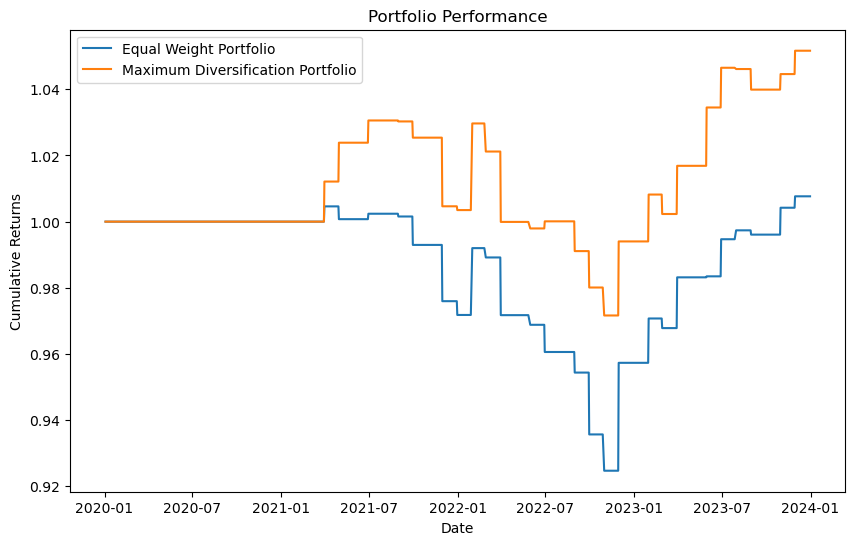

In [26]:
# (b)

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the ticker symbols for the 30 stocks (a diversified set from various sectors)
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "BRK-B", "JNJ", "V", "WMT",
    "JPM", "PG", "UNH", "DIS", "NVDA", "HD", "PYPL", "BAC", "VZ", "ADBE",
    "CMCSA", "NFLX", "KO", "NKE", "MRK", "PEP", "T", "PFE", "INTC", "CSCO"
]

# Define the backtest period
start_date = "2020-01-01"
end_date = "2023-12-31"

# Fetch the historical data
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

# Calculate daily returns
daily_returns = data.pct_change().dropna()

def rebalance_portfolio_with_lookback(data, initial_weights, optimize=False):
    monthly_data = data.resample('M').ffill()
    rebalanced_weights = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)

    for month in monthly_data.index[12:]:  # start rebalancing after one year
        past_year_data = data.loc[month - pd.DateOffset(years=1):month]
        past_year_returns = past_year_data.pct_change().dropna()
        cov_matrix = past_year_returns.cov() * 12  # Annualized covariance matrix
        standard_deviation = past_year_returns.std() * np.sqrt(12)
        
        if optimize:
            def neg_diversification_ratio(weights):
                weighted_volatility = np.dot(weights, standard_deviation)
                portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
                return -1 * (weighted_volatility / portfolio_volatility)
            
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            bounds = tuple((-1, 1) for _ in past_year_returns.columns)
            result = minimize(neg_diversification_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
            optimized_weights = result.x
            rebalanced_weights.loc[month] = optimized_weights
        else:
            rebalanced_weights.loc[month] = initial_weights

    return rebalanced_weights.shift(1).dropna()

# Initialize equal weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
initial_weights_MDP = np.array([1/len(tickers)] * len(tickers))

# Rebalance portfolios using previous year's data
equal_weights = rebalance_portfolio_with_lookback(data, initial_weights, optimize=False)
MDP_weights = rebalance_portfolio_with_lookback(data, initial_weights_MDP, optimize=True)

# Calculate cumulative returns for each portfolio
def calculate_cumulative_returns(data, weights):
    daily_returns = data.pct_change().dropna()
    portfolio_returns = (daily_returns * weights.shift(1)).sum(axis=1)
    cum_returns = (1 + portfolio_returns).cumprod()
    return cum_returns

cum_returns_equal = calculate_cumulative_returns(data, equal_weights)
cum_returns_optimized = calculate_cumulative_returns(data, MDP_weights)

# Calculate metrics
def calculate_metrics(cumulative_returns):
    daily_returns = cumulative_returns.pct_change().dropna()
    annualized_mean_return = np.mean(daily_returns) * 252
    annualized_std_dev = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = annualized_mean_return / annualized_std_dev
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return annualized_mean_return, annualized_std_dev, sharpe_ratio, max_drawdown

metrics_equal = calculate_metrics(cum_returns_equal)
metrics_optimized = calculate_metrics(cum_returns_optimized)

print("- Equal Weight Portfolio Metrics:")
print(f"Annualized Mean Return: {metrics_equal[0]}")
print(f"Annualized Return Standard Deviation: {metrics_equal[1]}")
print(f"Sharpe Ratio: {metrics_equal[2]}")
print(f"Maximum Drawdown: {metrics_equal[3]}")

print("- Maximum Diversification Portfolio Metrics:")
print(f"Annualized Mean Return: {metrics_optimized[0]}")
print(f"Annualized Return Standard Deviation: {metrics_optimized[1]}")
print(f"Sharpe Ratio: {metrics_optimized[2]}")
print(f"Maximum Drawdown: {metrics_optimized[3]}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_equal, label='Equal Weight Portfolio')
plt.plot(cum_returns_optimized, label='Maximum Diversification Portfolio')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


# SUMMARY

- 기존 CAPM이론은 단순함과 명확성을 뛰어나지만 강력한 가정으로 인해 실제 포트폴리오 관리에 사용될 수 있는지에 대한 논쟁  

Risky assets of universe U:X_1, X_2,...,X_N 
V: covariance matrix  
C: correlation matrix  
$\sum  $: vector of asset volatilities  

Diversification ratio = $D(P) = \frac{P'\sum}{\sqrt{P'VP}}$  
(P = $(w_{P1},...,w_{PN}), \sum w_{Pi} = 1$)  


Most-Diversified Portfolio는 위의 Diversification ratio를 maximize하는 것이 목표  

※ 투자자들이 같은 비율로 현금을 빌려주고 빌릴 수 있다고 가정  
→ $Y_i = \frac{X_i}{\sigma_I} + (1-\frac{1}{\sigma_i})\$$ : synthetic assets  
($: risk-free asset)  

$Y_i$의 분산이 모두 1이 되면서 $\sum$ = 1 → $S'\sum$ = 1, $V_s = C$  
→ minimize $S'CS$  

Optimal portfolio M = $(\frac{w_{S1}}{\sigma_1},...,\frac{w_{SN}}{\sigma_N},(1-\sum^n_{i=1}\frac{w_{Si}}{\sigma_i}$)$)  

- properties  

$M = k\sigma^{-1}C^{-1}1$  

$\rho_{P,M} = \frac{P'\sigma C\sigma M}{\sigma_P\sigma_M} = D(P)\frac{k}{\sigma_M}$  

- $\rho_{i,M} = \frac{k}{\sigma_M}$  

- $k = \frac{\sigma_M}{D(M)}$  
→ $\rho_{P,M} = \frac{D(P)}{D(M)}$  

CAPM: $R_P = \alpha_P + \frac{\sigma_P}{\sigma_M}\frac{D(P)}{D(M)}R_M + \epsilon_P$  


※ 모든 주식이 동일한 변동성을 지니고 있다면 MDP = minimum-variance portfolio  

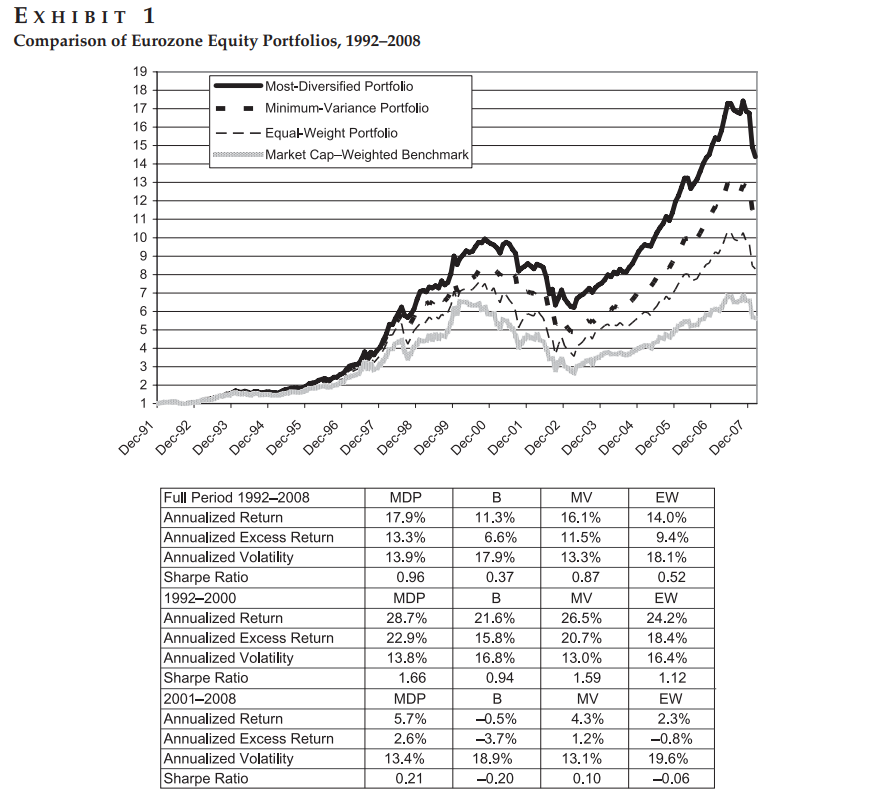




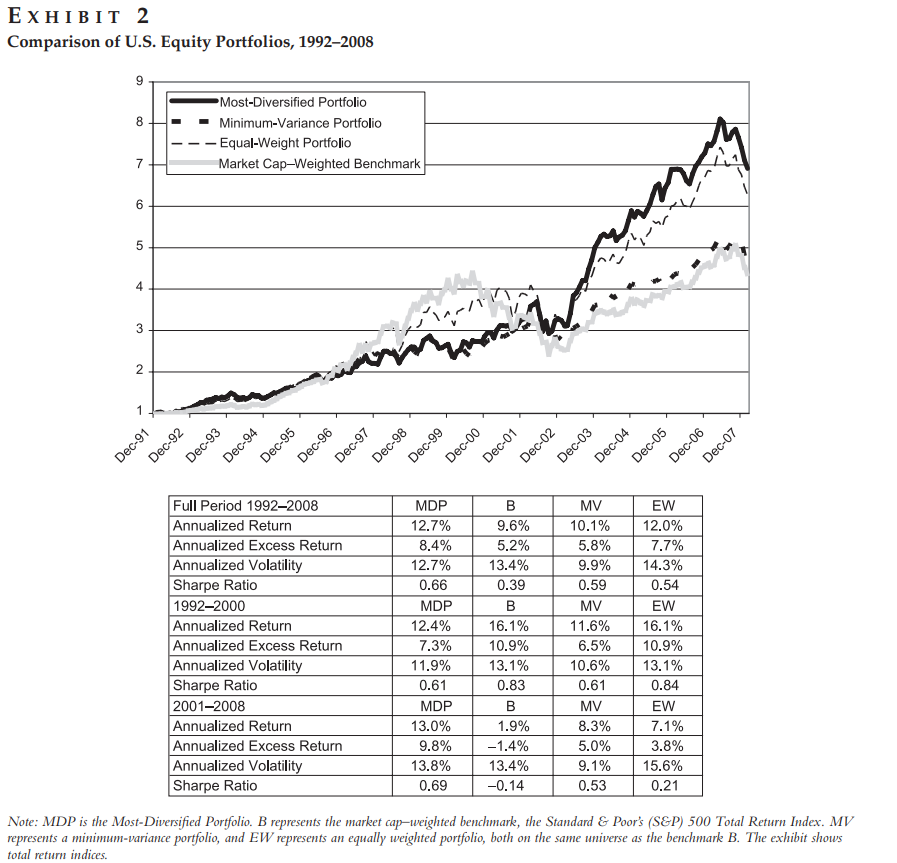

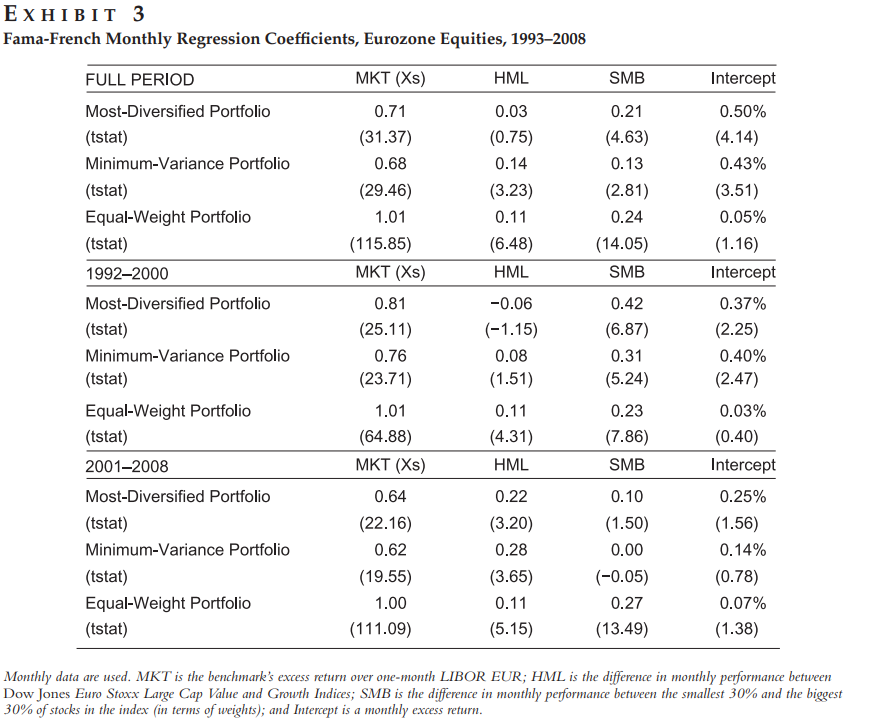

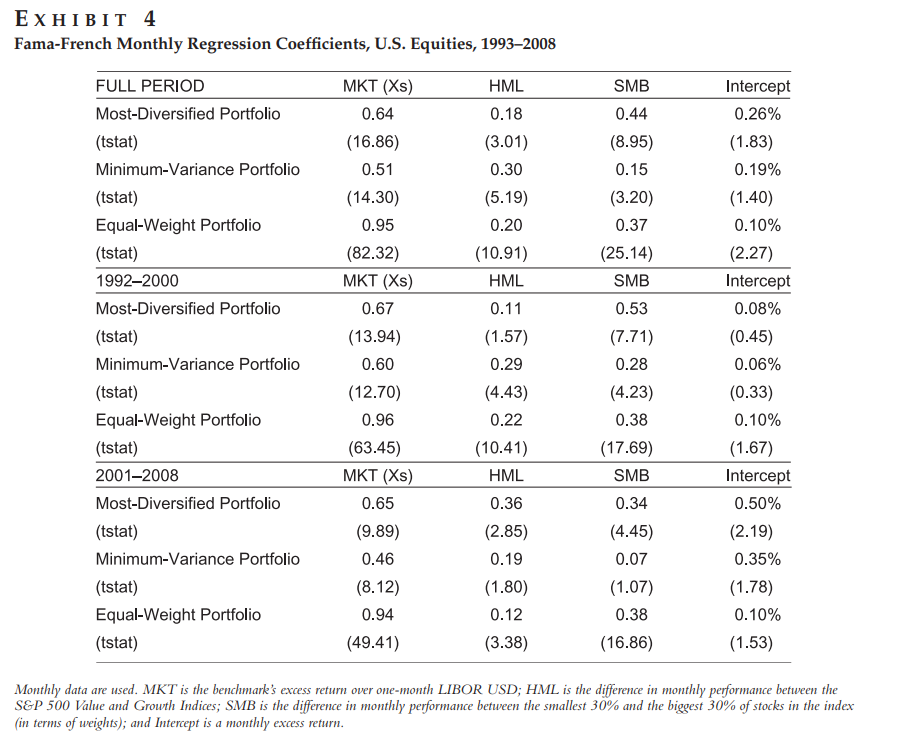

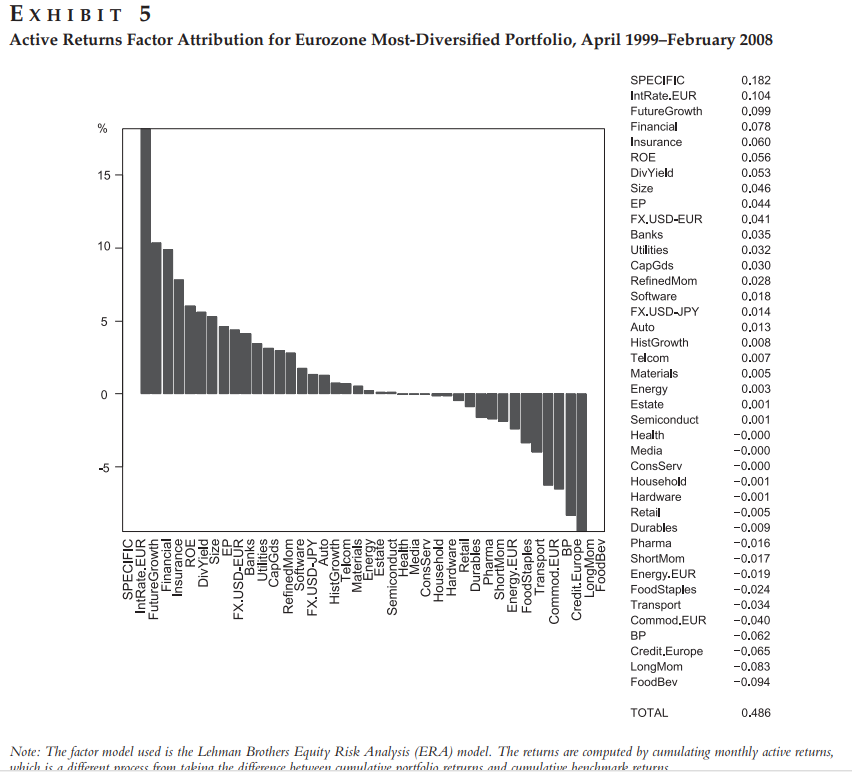

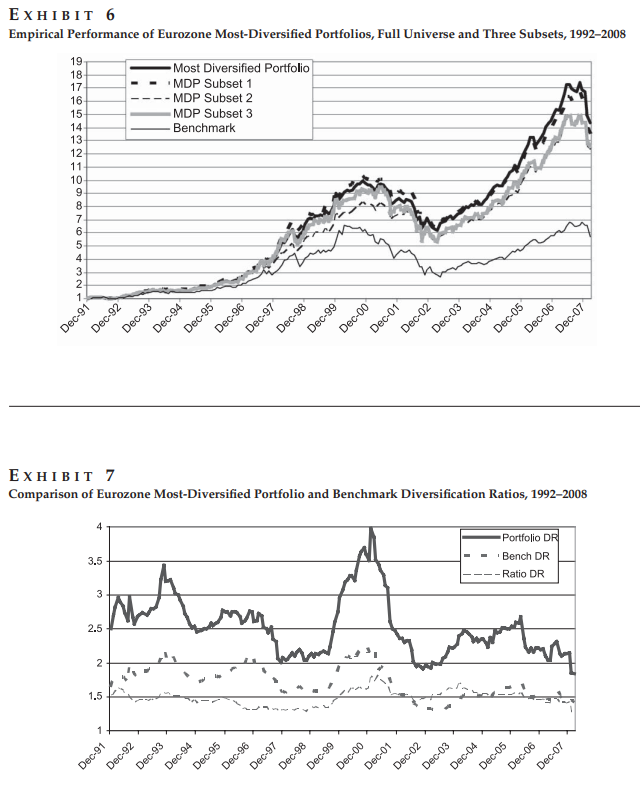

## Conclusion  

- MDP를 사전에 활용하는 것은 어려움이 있으나 사후에 활용하는 것은 minimum-variance portfolio, equal-weight portfolio 보다 더 효율적이다.  
- 주식 시장에 특정한 가설이 아니기 때문에 다른 자산 클래스에도 활용가능
